## OVERVIEW
---
* Signal Processing and Signal Denoising
 * Wavelet Denoising
 * Average Smoothing
* Exploratory Data Analysis
* Store Sales Forecasting
 * Naive Approach
 * Moving Average
 * ARIMA
 * FBProphet
* Error Rate comparison of models

In [ ]:

import numpy as np
import pandas as pd
from math import log, floor
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neighbors import KDTree

import warnings
warnings.filterwarnings("ignore")

In [2]:
calendar = pd.read_csv('data/calendar.csv')
selling_prices = pd.read_csv('data/sell_prices.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
sales_train_val = pd.read_csv('data/sales_train_validation.csv')

In [3]:
ids = sorted(list(set(sales_train_val['id'])))

In [4]:
sales_train_val.loc[sales_train_val['id'] == ids[4]]
d_cols = [c for c in sales_train_val.columns if 'd_' in c]

## SIGNAL PROCESSING
---

In [5]:
#SELECTING RANDOM STORE SALES DATA
sample_1 = sales_train_val.loc[sales_train_val['id'] == ids[5]].set_index('id')[d_cols].values[0][400:500]
sample_2 = sales_train_val.loc[sales_train_val['id'] == ids[10]].set_index('id')[d_cols].values[0][400:500]
sample_3 = sales_train_val.loc[sales_train_val['id'] == ids[13]].set_index('id')[d_cols].values[0][400:500]
sample_4 = sales_train_val.loc[sales_train_val['id'] == ids[26]].set_index('id')[d_cols].values[0][400:500]
sample_5 = sales_train_val.loc[sales_train_val['id'] == ids[50]].set_index('id')[d_cols].values[0][400:500]

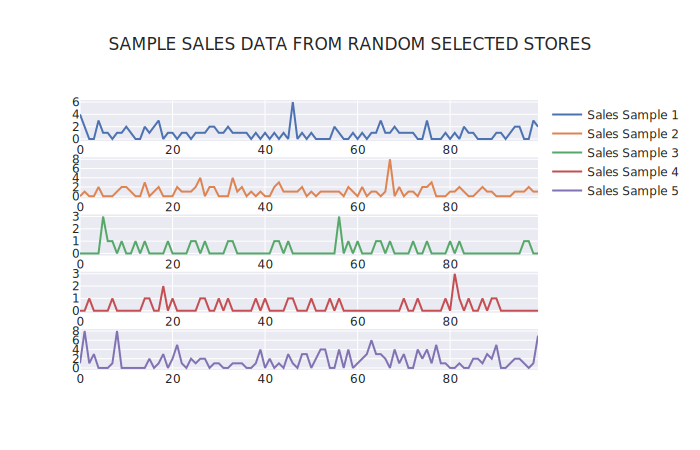

In [8]:
#SHOW FIG
fig = make_subplots(rows =5,cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = sample_1, mode= 'lines',name = 'Sales Sample 1'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = sample_2, mode= 'lines',name = 'Sales Sample 2'),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = sample_3, mode= 'lines',name = 'Sales Sample 3'),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = sample_4, mode= 'lines',name = 'Sales Sample 4'),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = sample_5, mode= 'lines',name = 'Sales Sample 5'),row=5,col=1)

fig.update_layout(title = 'SAMPLE SALES DATA FROM RANDOM SELECTED STORES', height=650, template='seaborn')

fig.show(renderer='svg')

### DENOISING SIGNAL (WAVELET METHOD)
----

In [13]:
#WAVELET DENOISING METHOD

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(data, wavelet='db4', level=1):
    coeff = pywt.wavedec(data, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [14]:
den_sample_1 = denoise_signal(sample_1)
den_sample_2 = denoise_signal(sample_2)
den_sample_3 = denoise_signal(sample_3)
den_sample_4 = denoise_signal(sample_4)
den_sample_5 = denoise_signal(sample_5)

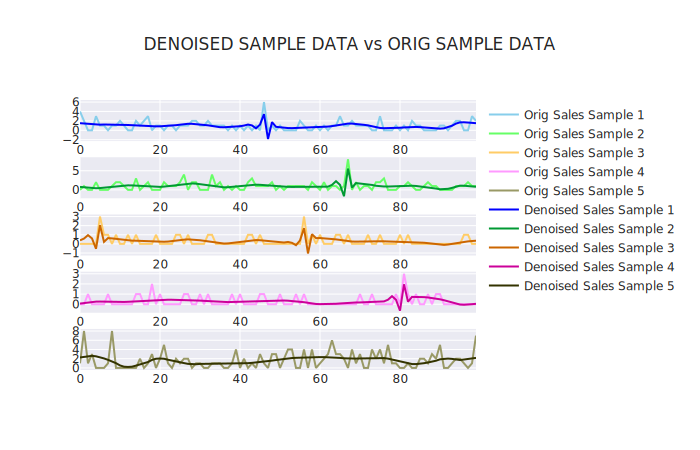

In [15]:
#SHOW FIG
fig = make_subplots(rows =5,cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = sample_1, mode= 'lines',name = 'Orig Sales Sample 1',
                         marker_color='skyblue'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = sample_2, mode= 'lines',name = 'Orig Sales Sample 2',
                         marker_color='rgb(102, 255, 102)'),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = sample_3, mode= 'lines',name = 'Orig Sales Sample 3',
                         marker_color='rgb(255, 204, 102)'),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = sample_4, mode= 'lines',name = 'Orig Sales Sample 4',
                         marker_color='rgb(255, 153, 255)'),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = sample_5, mode= 'lines',name = 'Orig Sales Sample 5',
                         marker_color='rgb(153, 153, 102)'),row=5,col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = den_sample_1, mode= 'lines',name = 'Denoised Sales Sample 1',
                         marker_color='blue'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = den_sample_2, mode= 'lines',name = 'Denoised Sales Sample 2',
                         marker_color='rgb(0, 153, 51)'),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = den_sample_3, mode= 'lines',name = 'Denoised Sales Sample 3',
                         marker_color='rgb(204, 102, 0)'),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = den_sample_4, mode= 'lines',name = 'Denoised Sales Sample 4',
                         marker_color='rgb(204, 0, 153)'),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = den_sample_5, mode= 'lines',name = 'Denoised Sales Sample 5',
                         marker_color='rgb(51, 51, 0)'),row=5,col=1)

fig.update_layout(title = 'DENOISED SAMPLE DATA vs ORIG SAMPLE DATA', height=650, template='seaborn')

fig.show(renderer='svg')


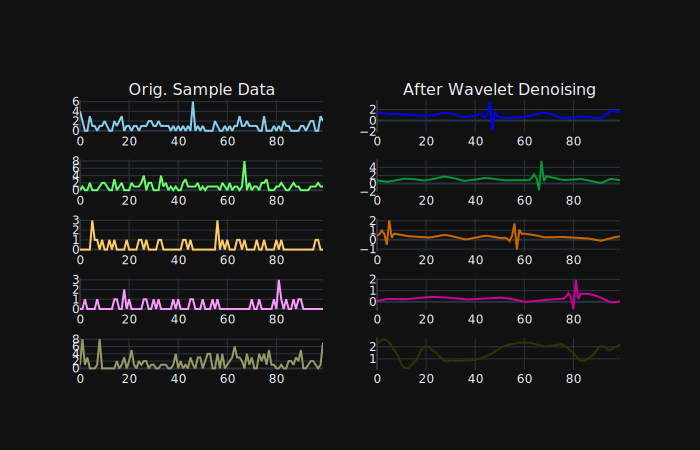

In [16]:
#SHOW FIG
fig = make_subplots(rows =5,cols=2, subplot_titles=('Orig. Sample Data', 'After Wavelet Denoising'))

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = sample_1, mode= 'lines',name = 'Orig Sales Sample 1',
                         marker_color='skyblue', showlegend=False),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = sample_2, mode= 'lines',name = 'Orig Sales Sample 2',
                         marker_color='rgb(102, 255, 102)', showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = sample_3, mode= 'lines',name = 'Orig Sales Sample 3',
                         marker_color='rgb(255, 204, 102)', showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = sample_4, mode= 'lines',name = 'Orig Sales Sample 4',
                         marker_color='rgb(255, 153, 255)', showlegend=False),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = sample_5, mode= 'lines',name = 'Orig Sales Sample 5',
                         marker_color='rgb(153, 153, 102)', showlegend=False),row=5,col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = den_sample_1, mode= 'lines',name = 'Denoised Sales Sample 1',
                         marker_color='blue', showlegend=False),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = den_sample_2, mode= 'lines',name = 'Denoised Sales Sample 2',
                         marker_color='rgb(0, 153, 51)', showlegend=False),row=2,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = den_sample_3, mode= 'lines',name = 'Denoised Sales Sample 3',
                         marker_color='rgb(204, 102, 0)', showlegend=False),row=3,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = den_sample_4, mode= 'lines',name = 'Denoised Sales Sample 4',
                         marker_color='rgb(204, 0, 153)', showlegend=False),row=4,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = den_sample_5, mode= 'lines',name = 'Denoised Sales Sample 5',
                         marker_color='rgb(51, 51, 0)', showlegend=False),row=5,col=2)

fig.update_layout(width=700, template='plotly_dark')

fig.show(renderer = 'svg')

### DENOISING SIGNAL (AVERAGE SMOOTHING METHOD)
---

In [17]:
#Smoothing Method
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

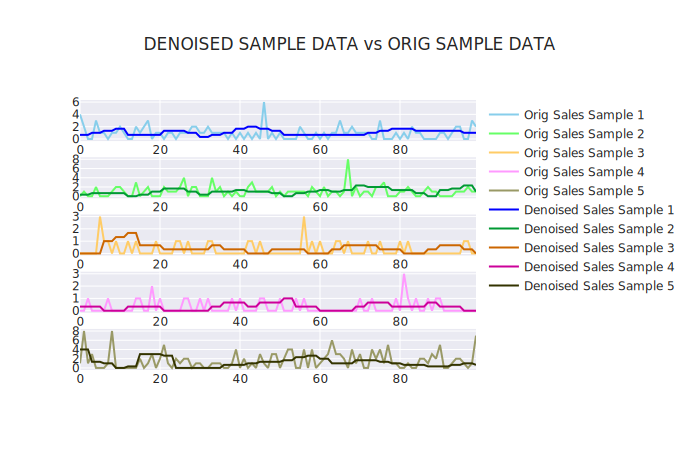

In [18]:
avsmoothing_sample_1 = average_smoothing(sample_1)
avsmoothing_sample_2 = average_smoothing(sample_2)
avsmoothing_sample_3 = average_smoothing(sample_3)
avsmoothing_sample_4 = average_smoothing(sample_4)
avsmoothing_sample_5 = average_smoothing(sample_5)



#SHOW FIG
fig = make_subplots(rows =5,cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = sample_1, mode= 'lines',name = 'Orig Sales Sample 1',
                         marker_color='skyblue'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = sample_2, mode= 'lines',name = 'Orig Sales Sample 2',
                         marker_color='rgb(102, 255, 102)'),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = sample_3, mode= 'lines',name = 'Orig Sales Sample 3',
                         marker_color='rgb(255, 204, 102)'),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = sample_4, mode= 'lines',name = 'Orig Sales Sample 4',
                         marker_color='rgb(255, 153, 255)'),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = sample_5, mode= 'lines',name = 'Orig Sales Sample 5',
                         marker_color='rgb(153, 153, 102)'),row=5,col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = avsmoothing_sample_1, mode= 'lines',name = 'Denoised Sales Sample 1',
                         marker_color='blue'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = avsmoothing_sample_2, mode= 'lines',name = 'Denoised Sales Sample 2',
                         marker_color='rgb(0, 153, 51)'),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = avsmoothing_sample_3, mode= 'lines',name = 'Denoised Sales Sample 3',
                         marker_color='rgb(204, 102, 0)'),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = avsmoothing_sample_4, mode= 'lines',name = 'Denoised Sales Sample 4',
                         marker_color='rgb(204, 0, 153)'),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = avsmoothing_sample_5, mode= 'lines',name = 'Denoised Sales Sample 5',
                         marker_color='rgb(51, 51, 0)'),row=5,col=1)

fig.update_layout(title = 'DENOISED SAMPLE DATA vs ORIG SAMPLE DATA', height=650, template='seaborn')

fig.show(renderer='svg')

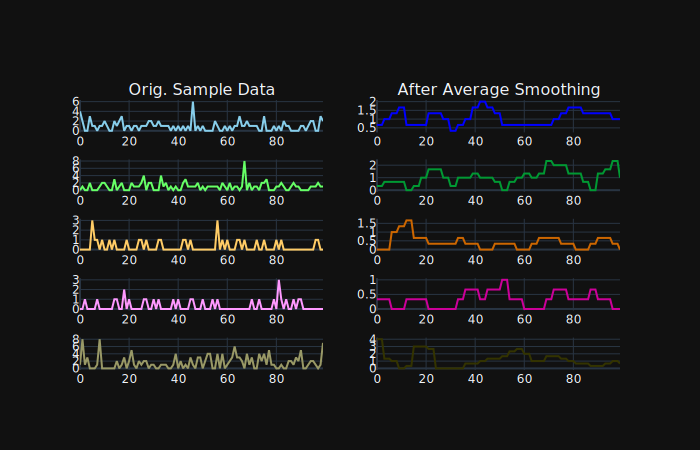

In [19]:
#SHOW FIG
fig = make_subplots(rows =5,cols=2, subplot_titles=('Orig. Sample Data', 'After Average Smoothing'))

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = sample_1, mode= 'lines',name = 'Orig Sales Sample 1',
                         marker_color='skyblue', showlegend=False),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = sample_2, mode= 'lines',name = 'Orig Sales Sample 2',
                         marker_color='rgb(102, 255, 102)', showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = sample_3, mode= 'lines',name = 'Orig Sales Sample 3',
                         marker_color='rgb(255, 204, 102)', showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = sample_4, mode= 'lines',name = 'Orig Sales Sample 4',
                         marker_color='rgb(255, 153, 255)', showlegend=False),row=4,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = sample_5, mode= 'lines',name = 'Orig Sales Sample 5',
                         marker_color='rgb(153, 153, 102)', showlegend=False),row=5,col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                         y = avsmoothing_sample_1, mode= 'lines',name = 'Denoised Sales Sample 1',
                         marker_color='blue', showlegend=False),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                         y = avsmoothing_sample_2, mode= 'lines',name = 'Denoised Sales Sample 2',
                         marker_color='rgb(0, 153, 51)', showlegend=False),row=2,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                         y = avsmoothing_sample_3, mode= 'lines',name = 'Denoised Sales Sample 3',
                         marker_color='rgb(204, 102, 0)', showlegend=False),row=3,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_4)),
                         y = avsmoothing_sample_4, mode= 'lines',name = 'Denoised Sales Sample 4',
                         marker_color='rgb(204, 0, 153)', showlegend=False),row=4,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(sample_5)),
                         y = avsmoothing_sample_5, mode= 'lines',name = 'Denoised Sales Sample 5',
                         marker_color='rgb(51, 51, 0)', showlegend=False),row=5,col=2)

fig.update_layout(width=700, template='plotly_dark')

fig.show(renderer='svg')

## STORE SALES VISUALIZATION
---

In [20]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = selling_prices.store_id.unique()
means = []

### ROLLING AVERAGE OF SALES (WINDOW = 90)
---

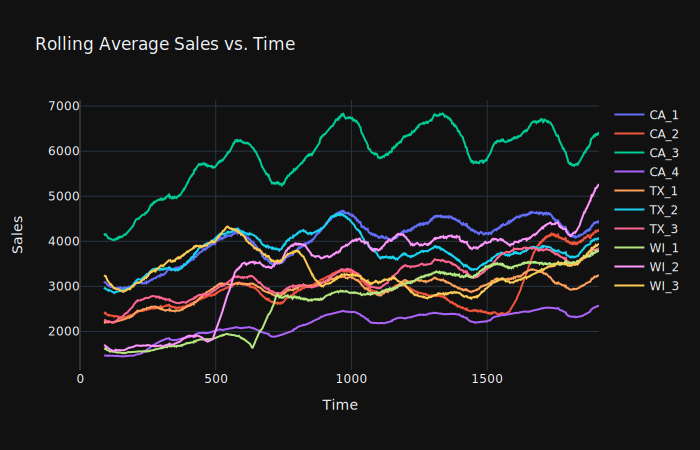

In [21]:

fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time", template = 'plotly_dark')
fig.show(renderer='svg')

#### BOXPLOT

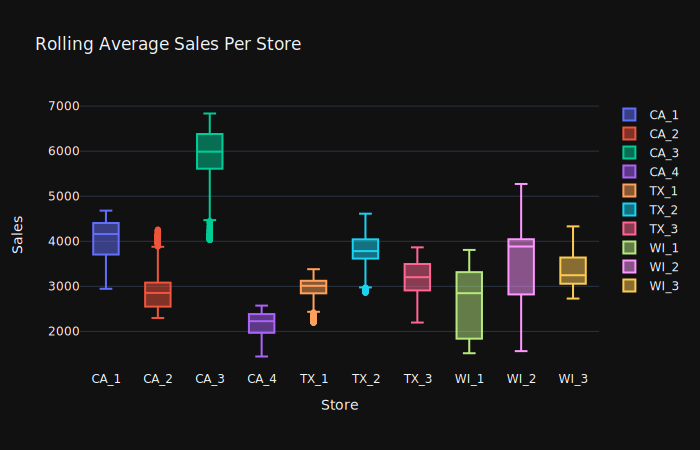

In [22]:

fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Store", title="Rolling Average Sales Per Store", template = 'plotly_dark')
fig.show(renderer='svg')

### MEAN SALES PER STORE
---

In [23]:
df = pd.DataFrame(data= np.transpose([means[:len(store_list)], store_list]), columns=['mean_sales','store_name'])

Text(0.5, 1.0, 'MEAN SALES PER STORE')

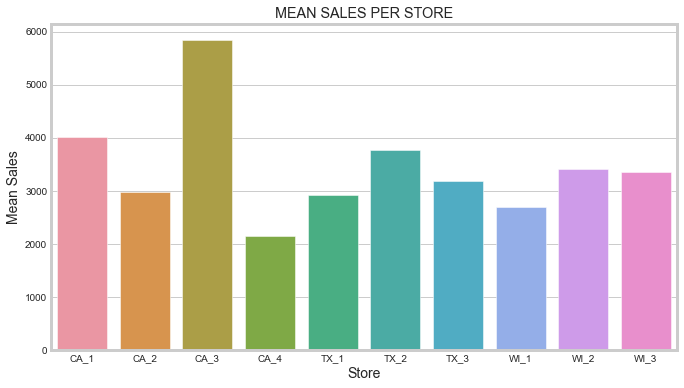

In [24]:
#SHOWFIG
plt.figure(figsize=(10,6))

sns.barplot(x=df.store_name, y=df.mean_sales )

plt.xlabel('Store', fontsize=14)
plt.ylabel('Mean Sales', fontsize=14)
plt.title('MEAN SALES PER STORE')


#### STORES IN CALIFORNIA

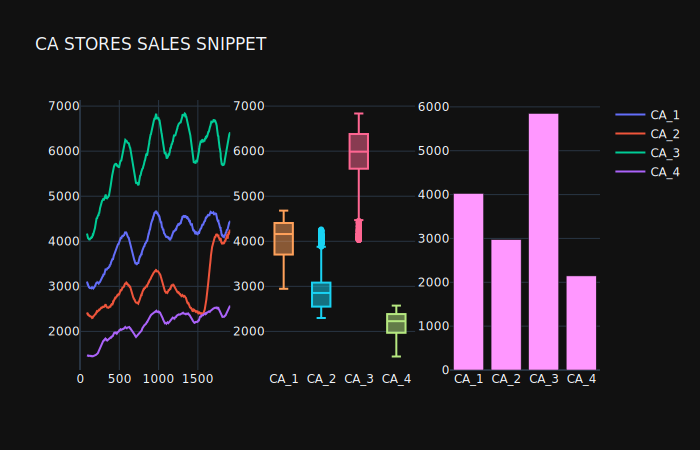

In [25]:
fig = make_subplots(rows=1,cols=3)

store_list_ca = [c for c in store_list if 'CA' in c]
store_list_tx = [c for c in store_list if 'TX' in c]
store_list_wi = [c for c in store_list if 'WI' in c]


for s in store_list_ca:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s,showlegend=True),row=1,col=1)
for s in store_list_ca:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s,showlegend=False),row=1,col=2)
    
fig.add_trace(go.Bar(x=df['store_name'][0:4],y=df.mean_sales,showlegend=False),row=1,col=3)
    
fig.update_layout(title="CA STORES SALES SNIPPET", template = 'plotly_dark')
fig.show(renderer='svg')

#### STORES IN TEXAS

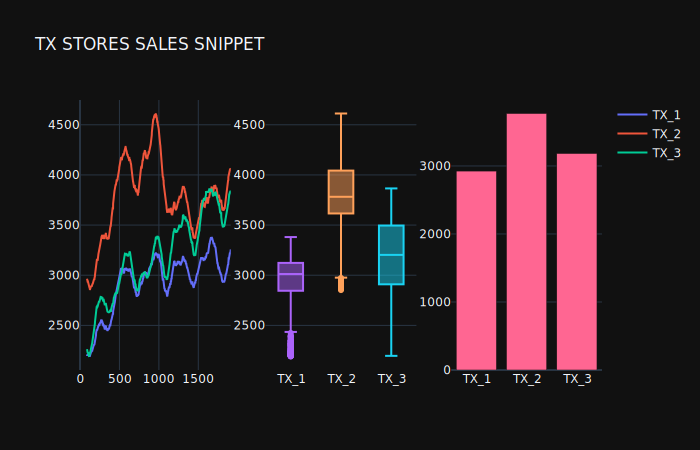

In [26]:
fig = make_subplots(rows=1,cols=3)

for s in store_list_tx:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s,showlegend=True),row=1,col=1)
for s in store_list_tx:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s,showlegend=False),row=1,col=2)
    
fig.add_trace(go.Bar(x=df['store_name'][4:7],y=df['mean_sales'][4:7],showlegend=False),row=1,col=3)
    
fig.update_layout(title="TX STORES SALES SNIPPET", template = 'plotly_dark')
fig.show(renderer='svg')

#### STORES IN WISCONSIN

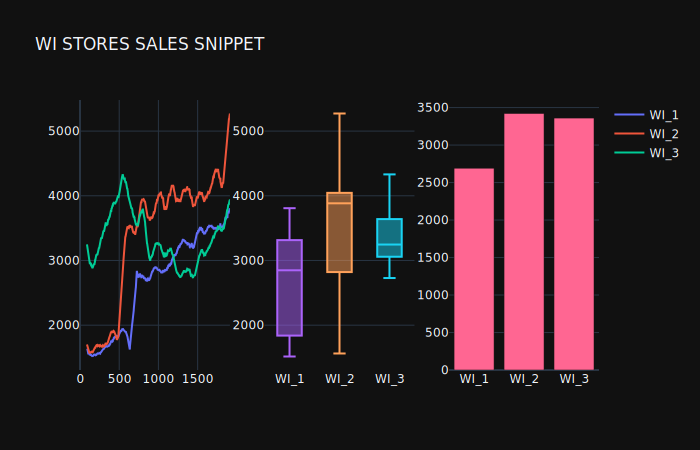

In [27]:
fig = make_subplots(rows=1,cols=3)

for s in store_list_wi:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s,showlegend=True),row=1,col=1)
for s in store_list_wi:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s,showlegend=False),row=1,col=2)
    
fig.add_trace(go.Bar(x=df['store_name'][-3:],y=df['mean_sales'][-3:],showlegend=False),row=1,col=3)
    
fig.update_layout(title="WI STORES SALES SNIPPET", template = 'plotly_dark')
fig.show(renderer='svg')

## FORCASTING
---

In [28]:
train_dataset = sales_train_val[d_cols[-100:-30]]
test_dataset = sales_train_val[d_cols[-30:]]

### NAIVE APPROACH
---

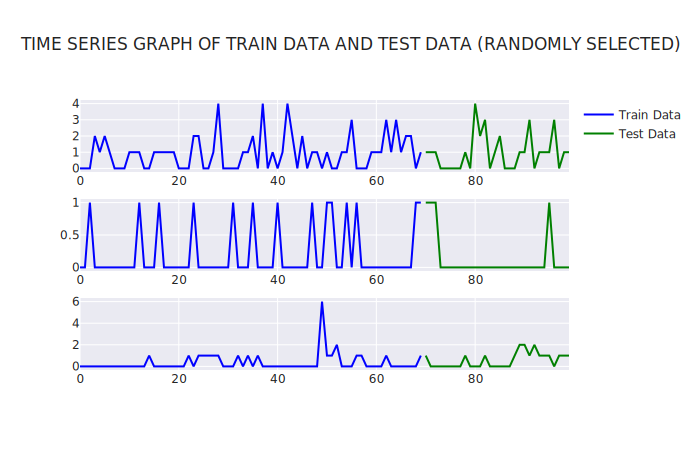

In [29]:
fig = make_subplots(rows=3,cols=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_dataset.loc[0], marker_color = 'blue', name = 'Train Data'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[0], marker_color = 'green', name= 'Test Data'),row=1,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_dataset.loc[1], marker_color = 'blue',showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[1], marker_color = 'green',showlegend=False),row=2,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_dataset.loc[2], marker_color = 'blue',showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[2], marker_color = 'green',showlegend=False),row=3,col=1)

fig.update_layout(title = 'TIME SERIES GRAPH OF TRAIN DATA AND TEST DATA (RANDOMLY SELECTED)', template = 'seaborn')

fig.show(renderer='svg')

In [30]:
predictions = []

for i in range(len(test_dataset.columns)):
    
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(test_dataset[test_dataset.columns[i-1]].values)

In [31]:
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_rate_naive = np.linalg.norm((predictions[:3] - test_dataset.values[:3]) / len(predictions[0]))

#### (MAE, MSE, RMSE)

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:   ', mean_absolute_error(predictions[1], test_dataset.values[1]))
print('Mean Squared Error:   ', mean_squared_error(predictions[1], test_dataset.values[1]))
print('Root Mean Squared Error:   ', np.sqrt(mean_squared_error(predictions[1], test_dataset.values[1])))



Mean Absolute Error:    0.1
Mean Squared Error:    0.1
Root Mean Squared Error:    0.31622776601683794


#### TRUE VALUE AND PREDICTION COMPARISON

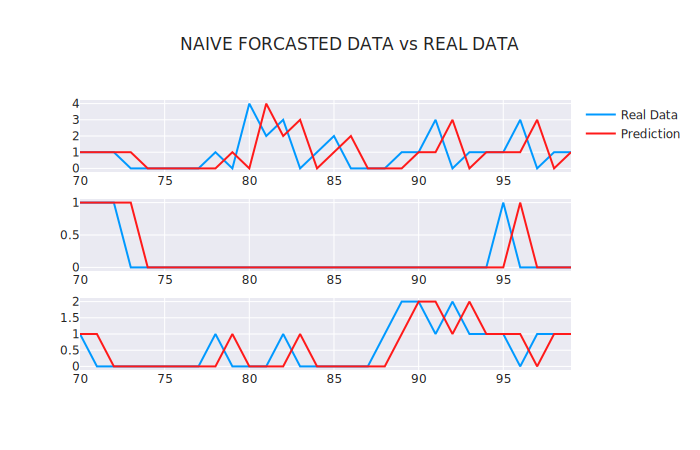

In [33]:
fig = make_subplots(rows=3,cols=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[0], marker_color = 'rgb(0, 153, 255)', name= 'Real Data'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[0], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=1,col=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[1], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[1], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=2,col=1)



fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[2], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[2], marker_color = 'rgb(255, 26, 26)', name= 'Prediction'),row=3,col=1)


fig.update_layout(title = 'NAIVE FORCASTED DATA vs REAL DATA', template = 'seaborn', width=700)

fig.show(renderer='svg')

### AVERAGE MOVING METHOD
---

In [34]:
predictions = []
for i in range(len(test_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))

In [35]:
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_rate_m_ave = np.linalg.norm((predictions[:3] - test_dataset.values[:3]) / len(predictions[0]))

#### TRUE VALUE AND PREDICTION COMPARISON

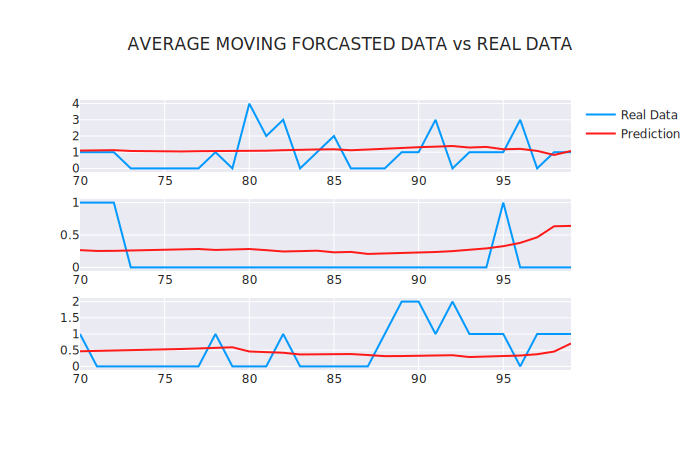

In [36]:
fig = make_subplots(rows=3,cols=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[0], marker_color = 'rgb(0, 153, 255)', name= 'Real Data'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[0], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=1,col=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[1], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[1], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=2,col=1)



fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[2], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[2], marker_color = 'rgb(255, 26, 26)', name= 'Prediction'),row=3,col=1)


fig.update_layout(title = 'AVERAGE MOVING FORCASTED DATA vs REAL DATA', template = 'seaborn', width=700)

fig.show(renderer='svg')

#### (MAE, MSE, RMSE)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:   ', mean_absolute_error(predictions[1], test_dataset.values[1]))
print('Mean Squared Error:   ', mean_squared_error(predictions[1], test_dataset.values[1]))
print('Root Mean Squared Error:   ', np.sqrt(mean_squared_error(predictions[1], test_dataset.values[1])))



Mean Absolute Error:    0.35360333601171184
Mean Squared Error:    0.1569310939434604
Root Mean Squared Error:    0.3961452939812114


### ARIMA METHOD
---

In [38]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_rate_arima = np.linalg.norm(predictions[:3] - test_dataset.values[:3])/len(predictions[0])

#### TRUE VALUE AND PREDICTION COMPARISON

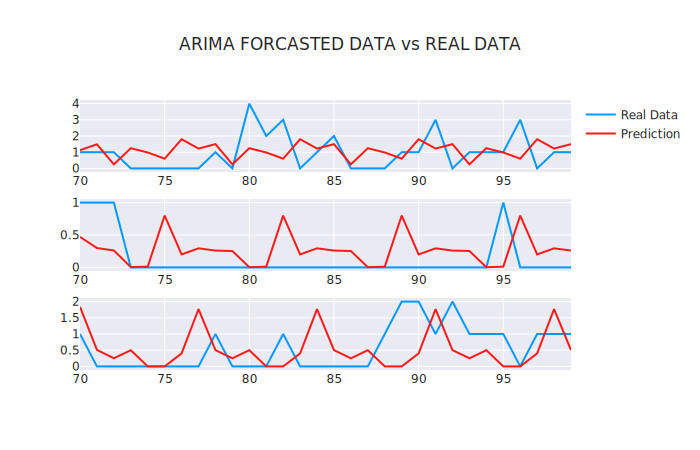

In [39]:
fig = make_subplots(rows=3,cols=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[0], marker_color = 'rgb(0, 153, 255)', name= 'Real Data'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[0], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=1,col=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[1], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[1], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=2,col=1)



fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[2], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[2], marker_color = 'rgb(255, 26, 26)', name= 'Prediction'),row=3,col=1)


fig.update_layout(title = 'ARIMA FORCASTED DATA vs REAL DATA', template = 'seaborn', width=700)

fig.show(renderer='svg')

#### (MAE, MSE, RMSE)

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:   ', mean_absolute_error(predictions[1], test_dataset.values[1]))
print('Mean Squared Error:   ', mean_squared_error(predictions[1], test_dataset.values[1]))
print('Root Mean Squared Error:   ', np.sqrt(mean_squared_error(predictions[1], test_dataset.values[1])))

Mean Absolute Error:    0.3326803193099927
Mean Squared Error:    0.1941170065566719
Root Mean Squared Error:    0.44058711574065795


### FBPROPHET FORCASTING METHOD

In [44]:
predictions = []
day = ["2020-01-" + str(i) for i in range(1, 31)]

for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    df = pd.DataFrame(np.transpose([day, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions)
error_rate_prophet = np.linalg.norm((predictions[:3] - test_dataset.values[:3]) / len(predictions[0]))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


#### TRUE VALUE AND PREDICTION COMPARISON

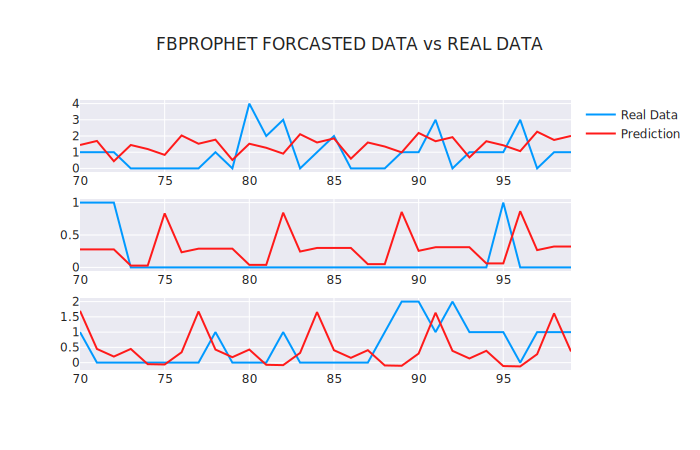

In [45]:
fig = make_subplots(rows=3,cols=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[0], marker_color = 'rgb(0, 153, 255)', name= 'Real Data'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[0], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=1,col=1)


fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[1], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[1], marker_color = 'rgb(255, 26, 26)', name= 'Test Data',showlegend=False),row=2,col=1)



fig.add_trace(go.Scatter(x=np.arange(70,100),y=test_dataset.loc[2], marker_color = 'rgb(0, 153, 255)',showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=predictions[2], marker_color = 'rgb(255, 26, 26)', name= 'Prediction'),row=3,col=1)


fig.update_layout(title = 'FBPROPHET FORCASTED DATA vs REAL DATA', template = 'seaborn', width=700)

fig.show(renderer='svg')

#### (MAE, MSE, RMSE)

In [46]:
print('Mean Absolute Error:   ', mean_absolute_error(predictions[1], test_dataset.values[1]))
print('Mean Squared Error:   ', mean_squared_error(predictions[1], test_dataset.values[1]))
print('Root Mean Squared Error:   ', np.sqrt(mean_squared_error(predictions[1], test_dataset.values[1])))

Mean Absolute Error:    0.37160896591970277
Mean Squared Error:    0.22074446556878674
Root Mean Squared Error:    0.4698345087036357


In [49]:
model_err_rate = pd.DataFrame(index = ['Naive Approach', 'Moving Average', 'ARIMA', 'FBProphet'],
                              data = [error_rate_naive, error_rate_m_ave, error_rate_arima, error_rate_prophet],
                              columns=['err'])
model_err_rate.err = model_err_rate.err *100

### COMPARISON BY ERROR RATE
---

Text(0, 0.5, 'Error %')

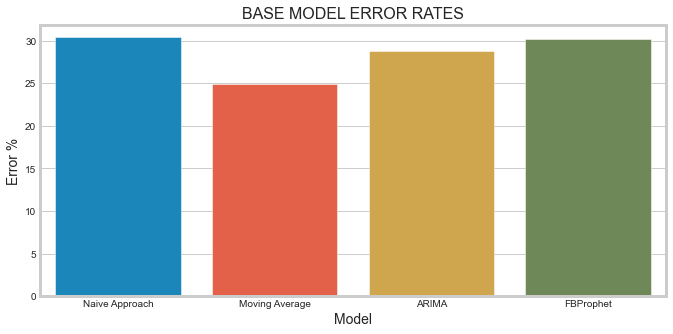

In [50]:
plt.figure(figsize=(10,5))

sns.barplot(x=model_err_rate.index, y=model_err_rate.err)

plt.title('BASE MODEL ERROR RATES', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Error %', fontsize=14)
